# Surface tools

In this tutorial, you'll learn how to access and use different surface tools available within [Xarray-Spatial](https://github.com/makepath/xarray-spatial) on top of Planetary Computer data. You'll use [Xarray-Spatial's surface tools](https://xarray-spatial.org/user_guide/surface.html) to quantify and visualize terrain landform data of the [Grand Teton National Park](https://www.nps.gov/grte/index.htm) from the [NASADEM](https://aka.ms/ai4edata-nasadem) digital elevation model. 

Analyzing and visualizing raster elevation surface data with these tools helps you identify specific patterns that may not be readily apparent in the original surface data. The functions in this example take an [Xarray DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) as their input and also return an Xarray DataArray that you can further process with familiar tools like NumPy or pandas.

This tutorial walks you through:

1. Loading and rendering the area of interest data using the Grand Teton National Park's latitude and longitude.
2. Using the following tools to create derivative rasters from the NASADEM data:

    * [Hillshade](#Hillshade): This tool visualizes and computes surface illumination of a raster surface area. The output is a shaded relief of a surface that considers illumination variables such as light source, angle, and shadows. 
    * [Slope](#Slope): For every cell within a raster surface area, this tool computes the inclination of a surface area, represented by a slope value.
    * [Curvature](#Curvature): This tool computes a number that indicates what direction the surface of a raster area is curving.
    * [Aspect](#Aspect): This tool computes the orientation of the slope for each cell within a raster area, represented by an aspect value.
    
The [NASADEM](https://github.com/microsoft/AIforEarthDatasets#nasadem) dataset used in this tutorial provides global topographic data at 1 arc-second (~30m) horizontal resolution. The data is derived primarily from data captured via the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) (SRTM) and is stored on Azure Blob Storage in [cloud-optimized GeoTIFF](https://www.cogeo.org/) (COG) format. The area of interest roughly covers the Grand Teton National Park in Wyoming, USA.

In [1]:
from dask.distributed import Client
import rasterio

import planetary_computer as pc
import pystac_client
import stackstac

from datashader import Canvas
from datashader.colors import Elevation
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from xrspatial.utils import height_implied_by_aspect_ratio


## Load and render the area of interest data

Before accessing the data, set up a Dask client:

In [2]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


Next, use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to select the COG covering Grand Teton National Park from the NASADEM dataset:

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
point = {"type": "Point", "coordinates": [-110.6818, 43.7904]}

search = catalog.search(collections=["nasadem"], intersects=point, limit=1)
nasadem_item = next(search.get_items())

nasadem_item

<Item id=NASADEM_HGT_n43w111>

Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) to load the NASADEM data and to reproject and resample it to an equal-area projection of ``EPSG:6933`` using the [bilinear](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling.bilinear) resampling method. These operations all happen in a single step. See [Reprojecting](reprojection.ipynb) to learn more about reprojecting and resampling.

There can be some performance problems with Dask when the chunk size is too small. To avoid this, also set `chunksize=2048` when calling the `stackstac.stack` function. Take a look at some [best practices](https://docs.dask.org/en/latest/array-best-practices.html#select-a-good-chunk-size) when working with Dask arrays to learn more.

In [4]:
elevation_raster = stackstac.stack(
    [pc.sign(nasadem_item).to_dict()],
    epsg=6933,
    resampling=rasterio.enums.Resampling.bilinear,
    chunksize=2048,
).squeeze()

elevation_raster

<xarray.DataArray 'stackstac-30b8e66d1623e221e498c0014ba859e5' (y: 3632, x: 3602)>
dask.array<getitem, shape=(3632, 3602), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2000-02-20
    id              <U19 'NASADEM_HGT_n43w111'
    band            <U9 'elevation'
  * x               (x) float64 -1.071e+07 -1.071e+07 ... -1.061e+07 -1.061e+07
  * y               (y) float64 5.089e+06 5.089e+06 ... 4.995e+06 4.995e+06
    proj:epsg       int64 4326
    proj:transform  object {0.0, 1.0, -0.0002777777777777778, 44.000138888888...
    proj:shape      object {3601}
    proj:bbox       object {-111.00013888888888, 42.999861111111116, -109.999...
    title           <U9 'Elevation'
    epsg            int64 6933
Attributes:
    spec:           RasterSpec(epsg=6933, bounds=(-10710003.909968996, 499534...
    crs:            epsg:6933
    transform:      | 26.80, 0.00,-10710003.91|\n| 0.00,-25.66, 5088530.14|\n...
    resolution_xy:  (26.80174451507628, 25.656756352633238)

With the area of interest data loaded into `elevation_raster`, use [Datashader](https://datashader.org/) to visualize the elevation values. Datashader is a data rasterization package highly compatible with Xarray-Spatial.  

First, create a Datashader [Canvas](https://datashader.org/api.html#datashader.Canvas) object that defines the area of interest in the dataspace as a basis for your visualization. Then use Datashader's [shade](https://datashader.org/api.html#datashader.transfer_functions.shade) function to generate a preview of the data, using the `Elevation` colormap and linear interpolation. This function converts the DataArray into an image where white and red pixels represent higher elevations, green and light green pixels represent medium elevations, and yellow and blue pixels represent lower elevations.

In [5]:
# get full extent of raster
full_extent = (
    elevation_raster.coords["x"].min().item(),
    elevation_raster.coords["y"].min().item(),
    elevation_raster.coords["x"].max().item(),
    elevation_raster.coords["y"].max().item(),
)

# get ranges
x_range = (full_extent[0], full_extent[2])
y_range = (full_extent[1], full_extent[3])

# set width and height
W = 300
H = height_implied_by_aspect_ratio(W, x_range, y_range)


cvs = Canvas(plot_width=W, plot_height=H, x_range=x_range, y_range=y_range)

elevation_small = cvs.raster(
    elevation_raster,
)

Visualize the preview image with Datashader's [shade](https://datashader.org/api.html#datashader.transfer_functions.shade) function using the `Elevation` colormap and `linear` interpolation. This function converts the DataArray into an image where white and red pixels represent higher elevations, green and light green pixels represent medium elevations, and yellow and blue pixels represent lower elevations.

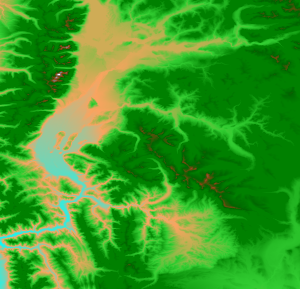

In [6]:
elevation_img = shade(elevation_small, cmap=Elevation, how="linear")
elevation_img

## Analyze data with surface tools

Now that the basic elevation data for the area of interest is available as the DataArray `elevation_raster`, you can use different tools to analyze this data.

### Hillshade

With Xarray-Spatial's [hillshade](https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html) tool, you can visualize terrain as a [shaded relief](https://en.wikipedia.org/wiki/Terrain_cartography#Shaded_relief). The shading of each cell within the raster data is based on a hypothetical light source. The output is based on each cell's orientation towards the simulated light source. Key components of this analysis include illumination source, angle, and shadows along with slope and aspect.  

Apply [hillshade](https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html) to the elevation raster data. Note that the return values of `hillshade` and other tools provided in Xarray-Spatial's surface toolsets are of the same type as the input type. Since you supply a Dask-backed DataArray, you'll get the hillshaded result as a non-computed Dask-backed DataArray.

In [7]:
from xrspatial import hillshade

hillshade_raster = hillshade(elevation_raster)
hillshade_raster

<xarray.DataArray 'hillshade' (y: 3632, x: 3602)>
dask.array<_trim, shape=(3632, 3602), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2000-02-20
    id              <U19 'NASADEM_HGT_n43w111'
    band            <U9 'elevation'
  * x               (x) float64 -1.071e+07 -1.071e+07 ... -1.061e+07 -1.061e+07
  * y               (y) float64 5.089e+06 5.089e+06 ... 4.995e+06 4.995e+06
    proj:epsg       int64 4326
    proj:transform  object {0.0, 1.0, -0.0002777777777777778, 44.000138888888...
    proj:shape      object {3601}
    proj:bbox       object {-111.00013888888888, 42.999861111111116, -109.999...
    title           <U9 'Elevation'
    epsg            int64 6933
Attributes:
    spec:           RasterSpec(epsg=6933, bounds=(-10710003.909968996, 499534...
    crs:            epsg:6933
    transform:      | 26.80, 0.00,-10710003.91|\n| 0.00,-25.66, 5088530.14|\n...
    resolution_xy:  (26.80174451507628, 25.656756352633238)

Generate a preview of hillshaded data and visualize the result with Datashader's [shade](https://datashader.org/api.html#datashader.transfer_functions.shade) function.

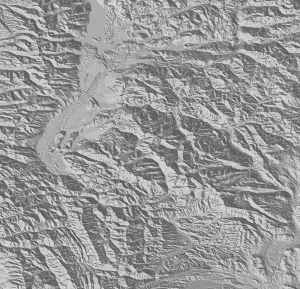

In [8]:
hillshade_img = shade(
    cvs.raster(hillshade_raster),
    cmap=["#333333", "#C7C7C7"],
    alpha=200,
)

hillshade_img

Applying `hillshade()` reveals a lot of detail in the 3D shape of the terrain.

To add even more detail, add the Elevation colormapped terrain from earlier and combine it with the hillshaded terrain using Datashader's [stack](https://datashader.org/api.html#datashader.transfer_functions.stack) function:

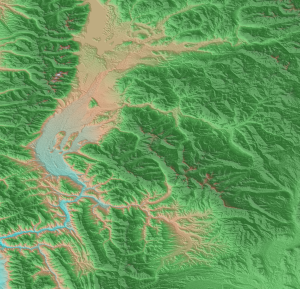

In [9]:
terrain_img = shade(elevation_small, cmap=Elevation, alpha=128, how="linear")
stack(hillshade_img, terrain_img)

### Slope
[Slope](https://en.wikipedia.org/wiki/Slope) is a measure of the inclination of a surface. In geography, *slope* is the rate of change in elevation for an area in a terrain relative to its surroundings.

Xarray-Spatial's [slope](https://xarray-spatial.org/reference/_autosummary/xrspatial.slope.slope.html) function returns the slope at each cell in degrees.

Apply [slope](https://xarray-spatial.org/reference/_autosummary/xrspatial.slope.slope.html) to the terrain data and generate a visualization where lighter colors represent higher slope values, and darker colors represent lower slope values:

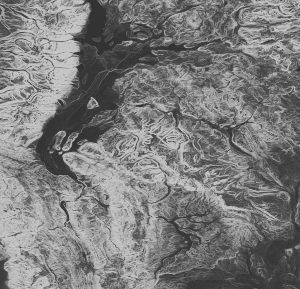

In [10]:
from xrspatial import slope

slope_raster = slope(elevation_raster)
slope_img = shade(cvs.raster(slope_raster), cmap=["#333333", "#C7C7C7"])
slope_img

To highlight especially steep slopes, first classify the slope data into nine categories with the [equal_interval](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.equal_interval.html) function. Then use Datashader's [stack](https://datashader.org/api.html#datashader.transfer_functions.stack) function to combine the resulting raster with the hillshaded and plain terrain rasters from the two previous examples. 

This produces an image with the steepest slopes clearly visible in fuchsia and red:

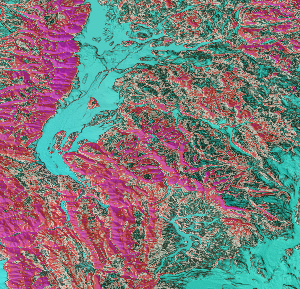

In [11]:
from datashader.colors import inferno, viridis
from xrspatial import equal_interval

slope_steepness_raster = equal_interval(slope_raster, k=9)
slope_steepness_img = shade(
    cvs.raster(slope_steepness_raster),
    cmap=["aqua", "black", "white", "red", "fuchsia"],
    alpha=128,
)

stack(elevation_img, hillshade_img, slope_steepness_img)

### Curvature
[Curvature](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/curvature.htm) is another derivative of a surface's elevation. Curvature represents the shape of the slope in an area and shows how quickly the slope is increasing or decreasing as you move along the surface of a raster data set. 

The Xarray-Spatial [curvature](https://xarray-spatial.org/reference/_autosummary/xrspatial.curvature.curvature.html) function returns a raster in units one hundredth (1/100) of the scaling factor (z-factor):

- A positive curvature means the surface is curving up (upwardly convex) at that cell. 
- A negative curvature means the surface is curving down (downwardly convex) at that cell. 
- A curvature of 0 means the surface is straight and constant in whatever angle it's sloped towards.

Reasonably expected values in the curvature raster for a hilly area (moderate relief) would be between -0.5 and 0.5, while for steep, rugged mountains (extreme relief), these can range as far as -4 and 4. For certain raster surfaces, even more extreme numbers are possible.

Apply the [curvature](https://xarray-spatial.org/reference/_autosummary/xrspatial.curvature.curvature.html) function to the elevation raster from earlier:

In [12]:
from xrspatial import curvature

curvature_raster = curvature(elevation_raster)
curvature_img = shade(cvs.raster(curvature_raster), cmap=inferno, alpha=128)

Next, use Datashader's [stack](https://datashader.org/api.html#datashader.transfer_functions.stack) function to combine the curvature data with the hillshaded and elevation data from earlier to produce an even more detailed picture of the slopes:

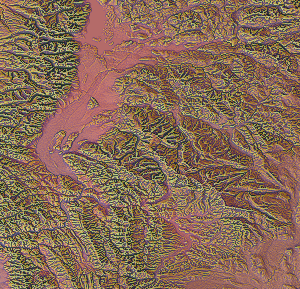

In [13]:
stack(elevation_img, hillshade_img, curvature_img)

### Aspect

[Aspect](https://en.wikipedia.org/wiki/Aspect_(geography)) represents the orientation of a slope in a terrain. Aspect is measured clockwise in degrees ranging from 0 to 360. An aspect value of 0 means the slope is north-facing, 90 means east-facing, 180 means south-facing, and 270 means west-facing.

The Xarray-Spatial [aspect](https://xarray-spatial.org/reference/_autosummary/xrspatial.aspect.aspect.html) function returns the aspect in degrees for each cell in an elevation terrain. This information can help determine which areas can potentially be exposed to sunlight at what time, for example.

Apply the [aspect](https://xarray-spatial.org/reference/_autosummary/xrspatial.aspect.aspect.html) function to the terrain data and Datashader's [stack](https://datashader.org/api.html#datashader.transfer_functions.stack) function to combine the aspect data with the hillshaded and plain terrain data.

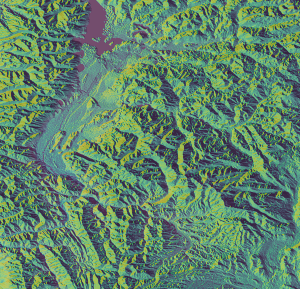

In [14]:
from xrspatial import aspect

aspect_raster = aspect(elevation_raster)
aspect_img = shade(cvs.raster(aspect_raster), cmap=viridis, alpha=128)

stack(elevation_img, hillshade_img, aspect_img)

## Next steps: analyze more datasets

Try using Xarray-Spatial's [hillshade](https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html), [slope](https://xarray-spatial.org/reference/_autosummary/xrspatial.slope.slope.html), [curvature](https://xarray-spatial.org/reference/_autosummary/xrspatial.curvature.curvature.html), and [aspect](https://xarray-spatial.org/reference/_autosummary/xrspatial.aspect.aspect.html) functions with terrain landform data from a different area of interest. Or try using these tools with the [USGS 3DEP Seamless DEMs](https://planetarycomputer.microsoft.com/dataset/3dep-seamless), a different elevation dataset available from the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog).